Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D ,BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.regularizers import l2
import tensorflow

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
#Test Mounting and exact path and rad-wrtie permission

with open('/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/foo.txt

Hello Google Drive!

In [ ]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 16 kB/s 
     |████████████████████████████████| 5.8 MB 9.2 MB/s 
     |████████████████████████████████| 1.4 MB 70.6 MB/s 
     |████████████████████████████████| 462 kB 89.9 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 7s (64.5 MB/s)
(Reading database ... 155676 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155654 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+c

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
train_path= "/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/"
test_path="/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Test/"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
## test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:
#class_names=np.array(class_names)

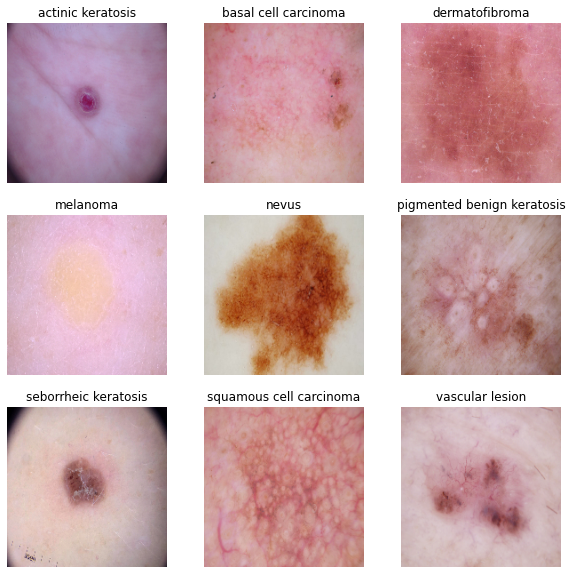

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    #plt.title(class_names[i] for i in labels)
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:


### Todo, choose an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = "categorical_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])


### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#model.summary()

Epoch 1/20
56/56 [==============================] - 21s 365ms/step - loss: 3.2027 - accuracy: 0.1775 - val_loss: 2.0729 - val_accuracy: 0.2506
Epoch 2/20
56/56 [==============================] - 15s 269ms/step - loss: 1.9616 - accuracy: 0.2506 - val_loss: 1.9048 - val_accuracy: 0.3244
Epoch 3/20
56/56 [==============================] - 15s 270ms/step - loss: 1.7474 - accuracy: 0.3616 - val_loss: 1.7612 - val_accuracy: 0.3445
Epoch 4/20
56/56 [==============================] - 15s 271ms/step - loss: 1.5913 - accuracy: 0.4369 - val_loss: 1.6086 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 15s 273ms/step - loss: 1.5058 - accuracy: 0.4894 - val_loss: 1.5032 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 15s 269ms/step - loss: 1.4177 - accuracy: 0.5056 - val_loss: 1.5918 - val_accuracy: 0.4474
Epoch 7/20
56/56 [==============================] - 15s 271ms/step - loss: 1.3581 - accuracy: 0.5234 - val_loss: 1.5237 - val_accuracy: 0.4541

### Visualizing training results

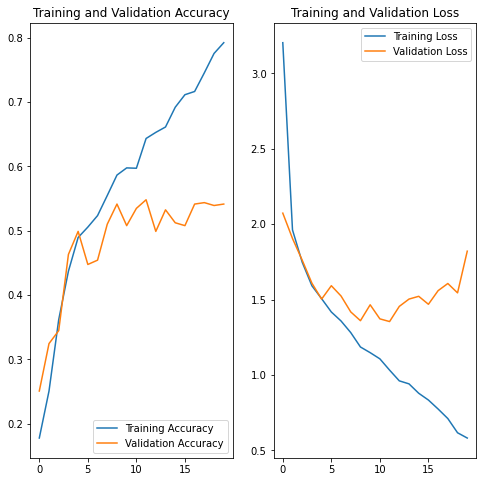

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
# Model Overfit or Underfit?
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 35ms/step - loss: 1.8209 - accuracy: 0.5414
Accuracy:  0.8599330186843872
Validation Accuracy:  0.5413870215415955
Loss:  0.39014801383018494
Validation Loss 1.8209096193313599


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit





### Write your findings here

4.5 Observations

    The accuracy of the model for the Training data set is at 92%. But the Validation accuracy is not in par with the training accuracy. The validation loss as observed is very high.
    This could also be indicative of some Overfit in the model.
    We could add some Dropout layers and remove the BatchNormalization layers.
    And by adding a few more layers, we could improve the accuracy by trying to extract more features.


In [20]:
# Create another model 

model_update=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
                             
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

In [21]:
# Compile 



model_update.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')



In [ ]:
#Train 

## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_update.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 66s 1s/step - loss: 2.2089 - accuracy: 0.2054 - val_loss: 2.1050 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 65s 1s/step - loss: 2.0359 - accuracy: 0.1903 - val_loss: 2.0503 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 65s 1s/step - loss: 2.0336 - accuracy: 0.2137 - val_loss: 2.0406 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 66s 1s/step - loss: 2.0311 - accuracy: 0.1936 - val_loss: 2.0194 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 66s 1s/step - loss: 2.0299 - accuracy: 0.2009 - val_loss: 2.0255 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 65s 1s/step - loss: 2.0143 - accuracy: 0.2137 - val_loss: 1.9814 - val_accuracy: 0.2640
Epoch 7/20
56/56 [==============================] - 65s 1s/step - loss: 1.9507 - accuracy: 0.2623 - val_loss: 1.8992 - val_accuracy: 0.2953
Epoch 8/20
56/56 [==

In [ ]:
# Visualize again .



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [ ]:
loss, accuracy = model_update.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model_update.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

Observations

    The model accuracy for Train data set has dropped . 
    The accuracy for the Validation set too.
    This is a much better model compared to the previous model as there seems to be No Overfit with the training accuracy  and validation accuracy .


In [ ]:


data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])



In [ ]:
image, label = next(iter(train_ds))
image=np.array(image,np.int32)  
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)  
  plt.imshow((augmented_image1))
  plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here



## You can use Dropout layer if there is an evidence of overfitting in your findings




model_augmented=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])





### Compiling the model

In [ ]:
## Your code goes here


model_augmented.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])



### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
## Your code goes here, note: train your model for 20 epochs


## Your code goes here, note: train your model for 20 epochs
epochs = 20
#history = model_augmented.fit(train_ds,epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])
history = model_augmented.fit(train_ds,epochs = epochs, verbose = 1, validation_data=val_ds)

Epoch 1/20
394/394 [==============================] - 23s 54ms/step - loss: 2.2077 - accuracy: 0.1214 - val_loss: 2.1946 - val_accuracy: 0.1153
Epoch 2/20
394/394 [==============================] - 21s 53ms/step - loss: 2.1943 - accuracy: 0.1214 - val_loss: 2.1939 - val_accuracy: 0.1265
Epoch 3/20
394/394 [==============================] - 21s 53ms/step - loss: 2.1940 - accuracy: 0.1236 - val_loss: 2.1938 - val_accuracy: 0.1153
Epoch 4/20
394/394 [==============================] - 21s 54ms/step - loss: 2.1940 - accuracy: 0.1236 - val_loss: 2.1938 - val_accuracy: 0.1265
Epoch 5/20
394/394 [==============================] - 21s 54ms/step - loss: 2.1939 - accuracy: 0.1221 - val_loss: 2.1937 - val_accuracy: 0.1265
Epoch 6/20
394/394 [==============================] - 21s 53ms/step - loss: 2.1939 - accuracy: 0.1260 - val_loss: 2.1938 - val_accuracy: 0.1265
Epoch 7/20
394/394 [==============================] - 21s 53ms/step - loss: 2.1940 - accuracy: 0.1209 - val_loss: 2.1938 - val_accuracy:

### Visualizing the results

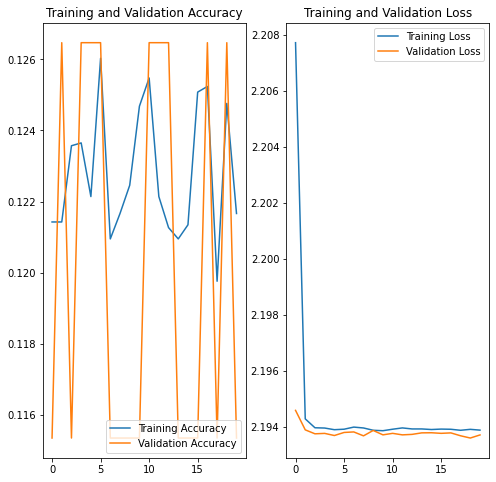

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model_augmented.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model_augmented.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

99/99 [==============================] - 2s 18ms/step - loss: 2.1937 - accuracy: 0.1153
Accuracy:  0.12507940828800201
Validation Accuracy:  0.1153479516506195
Loss:  2.1936864852905273
Validation Loss 2.193711280822754


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [103]:


train_path=data_dir_train

for i in class_names:
    directory =str(train_path)+'/'+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


Class Imbalance observed 



   The samples of various classes are not in equal proportion.
    There is a significant Class Imbalance observed.
    
    

*   The class with the least number of samples is Seborrheic Keratosis - 77
*  The class that dominates the data in terms of proportionate number of samples is Pigmented Benign Keratosis with sample size - 462






#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [102]:



path_to_training_dataset=train_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F297E97DC90>: 100%|██████████| 500/500 [00:10<00:00, 49.09 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F299219DED0>: 100%|██████████| 500/500 [00:10<00:00, 49.55 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F297E0F4E50>: 100%|██████████| 500/500 [00:10<00:00, 48.41 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=838x614 at 0x7F29922710D0>: 100%|██████████| 500/500 [00:56<00:00,  8.83 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F297E13BBD0>: 100%|██████████| 500/500 [00:41<00:00, 12.18 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F297E12EDD0>: 100%|██████████| 500/500 [00:10<00:00, 47.26 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F297E10B290>: 100%|██████████| 500/500 [00:22<00:00, 22.66 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A291FFDD0>: 100%|██████████| 500/500 [00:09<00:00, 52.44 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F299265BE10>: 100%|██████████| 500/500 [00:09<00:00, 51.87 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [104]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

5000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [82]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0025807.jpg_c714b81d-0bfe-46b7-8e0a-37f6c631e96e.jpg',
 '/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0033762.jpg_6adce8d7-0d17-4150-8656-b274cf3e6a87.jpg',
 '/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0031093.jpg_4b7ad395-4360-4f87-ab8c-4fbbea5b9bd3.jpg',
 '/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0025425.jpg_475553fc-f519-4c74-b96b-8b8ce7329959.jpg',
 '/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0025628.jpg_15d4bcdd-8262-4eda-a045-ed44377ffe17.jpg',
 '/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0029889.jpg_e76694fb-ea49-435d-99c2-0667e

In [83]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [60]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [105]:
print(data_dir_train)

for i in class_names:
    directory =str(data_dir_train)+'/'+i+'/'
    directory_out =str(data_dir_train)+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length_out
    print(f'{i} has {length_tot} samples.')


/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train
actinic keratosis has 500 samples.
basal cell carcinoma has 500 samples.
dermatofibroma has 500 samples.
melanoma has 500 samples.
nevus has 500 samples.
pigmented benign keratosis has 500 samples.
seborrheic keratosis has 500 samples.
squamous cell carcinoma has 500 samples.
vascular lesion has 1000 samples.


In [106]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = (df2)
#new_df = original_df.append(df2)

In [107]:
new_df['Label'].value_counts()

vascular lesion               3000
squamous cell carcinoma       3000
melanoma                      3000
seborrheic keratosis          3000
basal cell carcinoma          3000
nevus                         3000
actinic keratosis             3000
pigmented benign keratosis    3000
dermatofibroma                3000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [108]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [109]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7239 files belonging to 9 classes.
Using 5792 files for training.


#### **Todo:** Create a validation dataset

In [110]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7239 files belonging to 9 classes.
Using 1447 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [120]:
model_final=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    (Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')),
     BatchNormalization(),
    (Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')),
     BatchNormalization(),
    (MaxPooling2D(pool_size=(2, 2))),
    (BatchNormalization()),
    (Dropout(0.25)),
    
    Flatten(),
    Dense(128, activation='relu',kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [121]:
## your code goes here




model_final.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])



#### **Todo:**  Train your model

In [122]:
epochs = 30


history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
181/181 [==============================] - 23s 115ms/step - loss: 3.6015 - accuracy: 0.4435 - val_loss: 4.2593 - val_accuracy: 0.1306
Epoch 2/20
181/181 [==============================] - 22s 118ms/step - loss: 2.0791 - accuracy: 0.5294 - val_loss: 2.9965 - val_accuracy: 0.1838
Epoch 3/20
181/181 [==============================] - 21s 113ms/step - loss: 1.9939 - accuracy: 0.5568 - val_loss: 3.2059 - val_accuracy: 0.2903
Epoch 4/20
181/181 [==============================] - 21s 112ms/step - loss: 2.0074 - accuracy: 0.5825 - val_loss: 2.4217 - val_accuracy: 0.4845
Epoch 5/20
181/181 [==============================] - 21s 113ms/step - loss: 1.9321 - accuracy: 0.6312 - val_loss: 2.3517 - val_accuracy: 0.4679
Epoch 6/20
181/181 [==============================] - 21s 113ms/step - loss: 2.0860 - accuracy: 0.6329 - val_loss: 5.6402 - val_accuracy: 0.1444
Epoch 7/20
181/181 [==============================] - 22s 117ms/step - loss: 2.0564 - accuracy: 0.6554 - val_loss: 2.2598 - val_ac

#### **Todo:**  Visualize the model results

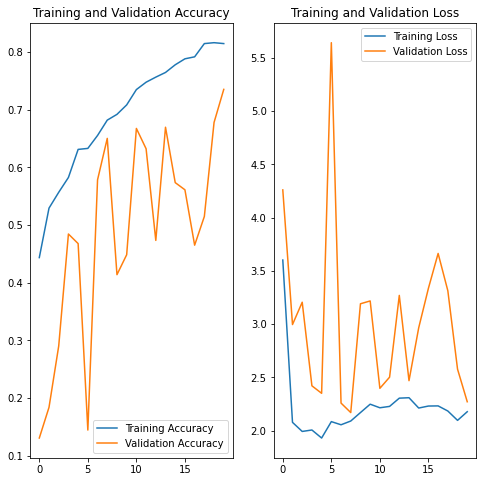

In [123]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



    The training accuracy seems to be nearly ~90%.
    The validation accuracy is nearly ~80%.
    Though the model accuracy has improved, the class rebalance has helped treat the overfitting to some extent.
    Much better models could be built or tried out using more epochs and more layers.




In [124]:
pred = model_final.predict(test_ds)

In [125]:
pred[0]

array([2.0354696e-02, 7.6212406e-01, 5.8820643e-02, 9.7786216e-04,
       4.3302686e-03, 1.0385600e-01, 3.6695003e-04, 4.4154271e-02,
       5.0152582e-03], dtype=float32)

In [126]:
pred

array([[2.03546956e-02, 7.62124062e-01, 5.88206425e-02, ...,
        3.66950029e-04, 4.41542715e-02, 5.01525821e-03],
       [3.55202593e-02, 2.88527366e-02, 8.60421360e-03, ...,
        3.91011648e-02, 6.93788052e-01, 6.41643186e-04],
       [8.16725101e-03, 5.02714282e-03, 1.29074644e-04, ...,
        1.64660669e-04, 8.79229486e-01, 2.58657092e-04],
       ...,
       [8.48908663e-01, 1.01293938e-03, 6.48058494e-06, ...,
        1.79378345e-04, 3.89486700e-02, 3.17801547e-04],
       [5.04242815e-02, 1.01110056e-01, 3.39029869e-03, ...,
        1.09585799e-01, 4.46786992e-02, 7.49349315e-03],
       [2.42330670e-01, 1.16765304e-02, 2.26074108e-03, ...,
        5.19892143e-04, 1.11113623e-04, 6.76656025e-04]], dtype=float32)